<a href="https://colab.research.google.com/github/morenourey/ENTREGABLES/blob/main/cnn_dataaug_catsdogs_v0_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Nuclio logo](https://nuclio.school/wp-content/uploads/2018/12/nucleoDS-newBlack.png)


## 1. Conectemonos a Google Drive y preparemos los datos

Los datos los podeis encontrar en esta URL de Google Drive (formato NPZ)

https://drive.google.com/file/d/1-OplAg9THXuzKC_oYAiB4wdBmCTdiy4z/view?usp=sharing <br>
https://drive.google.com/file/d/1-Svi93L-C7qAq2oJmtajfCJDjGdJTIaE/view?usp=sharing <br>
https://drive.google.com/file/d/1-Dpozh1KCEvuCYgYuaf98-PzHhHTo3F_/view?usp=sharing <br>

Movedlos a vuestro Drive!!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2. Librerias

Para empezar carguemos esas librerias que nos hacen falta

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd
import os

from tensorflow import keras as ks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


## 3. Definimos algunas constantes

In [5]:
ANCHO_IMAGEN=150
ALTURA_IMAGEN=150
IMAGE_SIZE=(ANCHO_IMAGEN, ALTURA_IMAGEN)
CANALES_IMAGENES=3

# Definimos la ruta donde teneis los archivos NPZ dentro de Google Drive
ruta = "/content/drive/MyDrive/NUCLIO/"

## 4. Preparamos los datos de entrenamiento

Los cargaremos del formato NPZ que comentamos en la última clase, y que tenemos en el Drive



In [6]:
dict_npz = np.load(ruta+'xy_train_img.npz')
x_train_img = dict_npz['x']
y_train_img = dict_npz['y']

dict_npz = np.load(ruta+'xy_test_img.npz')
x_test_img = dict_npz['x']
y_test_img = dict_npz['y']

dict_npz = np.load(ruta+'xy_val_img.npz')
x_val_img = dict_npz['x']
y_val_img = dict_npz['y']

x_train_scaled = x_train_img / 255.
x_test_scaled = x_test_img / 255.
x_val_scaled = x_val_img / 255.

In [7]:
print("Tamaño X train:", x_train_scaled.shape)
print("Tamaño Y train:", y_train_img.shape)

print("Tamaño X test:", x_test_scaled.shape)
print("Tamaño Y test:", y_test_img.shape)

print("Tamaño X val:", x_val_scaled.shape)
print("Tamaño Y val:", y_val_img.shape)



Tamaño X train: (5000, 150, 150, 3)
Tamaño Y train: (5000,)
Tamaño X test: (1000, 150, 150, 3)
Tamaño Y test: (1000,)
Tamaño X val: (1000, 150, 150, 3)
Tamaño Y val: (1000,)


## 5. Exploremos los datos

<Axes: xlabel='category'>

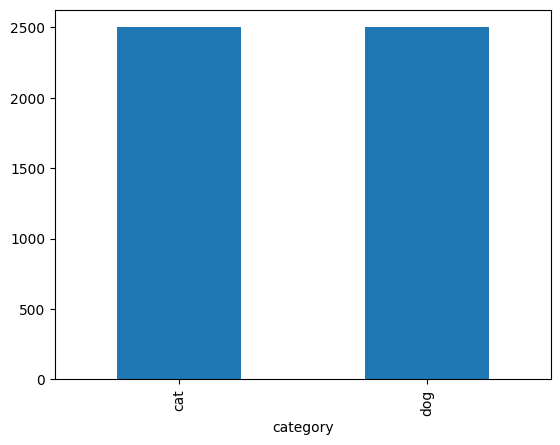

In [8]:
df_train = pd.DataFrame(y_train_img, columns=['category'])
df_train['category'].value_counts().plot.bar()

Como podemos ver tenemos 2500 ejemplos de cada clase... poquito para ser una red neuronal para vision por computador... ya vereis...

## 6. Pintemos una imagen

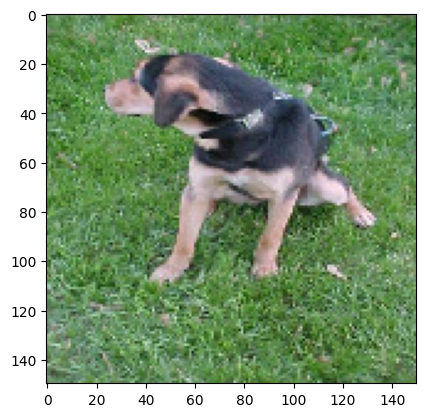

In [9]:
sample = random.choice(range(0,4999))
image = x_train_scaled[sample]
plt.imshow(image, cmap=plt.cm.binary)

## 7. Apilemos bloques para hacer el modelo

<img src="https://i.imgur.com/ebkMGGu.jpg" width="100%"/>

In [10]:
model = ks.Sequential()

model.add(ks.layers.Conv2D(16, (3, 3), activation='relu',
                           input_shape=(ANCHO_IMAGEN, ALTURA_IMAGEN, CANALES_IMAGENES)))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(ks.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(ks.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(ks.layers.Conv2D(128, (3, 3), activation='relu'))
model.add(ks.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(ks.layers.Flatten())
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.3))
model.add(ks.layers.Dense(512, activation='relu'))
model.add(ks.layers.Dropout(0.3))
model.add(ks.layers.Dense(1, activation='sigmoid')) # 1 de salida porque tenemos dos valores posibles 0 o 1 (tras aplicar un label encoder a dog y cat)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        9280      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

## 8. Montemos el optimizador compilando el modelo


In [11]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

## 9. Definamos un callback para el Early Stopping

**Early Stopping**

Prevenimos el sobre ajuste parando cuando tras 10 epochs y el error de la validacion no decrementa (estamos en una plateau)

In [12]:
callback_val_loss = EarlyStopping(monitor="val_loss", patience=5)
callback_val_accuracy = EarlyStopping(monitor="val_accuracy", patience=10)

## 10. Preparamos los datos

Haremos un one-hot encoding que nos va a ir bien para nuestra clasificación, porque lo que viene de serie son cadena de texto 'dog' y 'cat'

In [13]:
y_train_img

array(['cat', 'cat', 'cat', ..., 'dog', 'dog', 'dog'], dtype='<U3')

In [14]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y_train_img)
y_train_encoded = le.transform(y_train_img)
y_val_encoded = le.transform(y_val_img)
y_test_encoded = le.transform(y_test_img)

In [15]:
y_train_encoded

array([0, 0, 0, ..., 1, 1, 1])

## 11. Transformador de imagenes a datos consumibles por la red neuronal

**De entrenamiento**

Aquí incluiremos nuestra parte de generación de imagenes (con código de partida)

In [24]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    featurewise_center=True,
    samplewise_center=True,
    featurewise_std_normalization=True,
    samplewise_std_normalization=True,
    zca_whitening=True,
    horizontal_flip=True,
    vertical_flip=True

    # Definamos las transformaciones

    )

train_generator = train_datagen.flow(
    x_train_img,  # Aquí hay que usar datos NO re-escalados... de ahi que no usemos x_train_rescaled!
    y_train_encoded,
    batch_size=30
)

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1451: UserWarning: This ImageDataGenerator specifies `zca_whitening` which overrides setting of`featurewise_std_normalization`.
  warnings.warn(


**De validacion (test no lo necesita)**

Fijaos que aquí la única modificación es un re-escalado, nada de modificaciones

In [25]:
validation_datagen = ImageDataGenerator(
    rescale=1./255
    )
validation_generator = validation_datagen.flow(
    x_val_img,
    y_val_encoded,
    batch_size=20
)


No tiene mala pinta!!

## 12. Veamos que pinta tiene el generador de datos

A rellenar para ver que nos da el generador de imagenes nuevas

In [26]:
sample = random.choice(range(0,1457))

example_generator = train_datagen.flow(
    x_train_img[sample:sample+1],
    y_train_encoded[sample:sample+1],
    batch_size=20
    )

/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1885: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


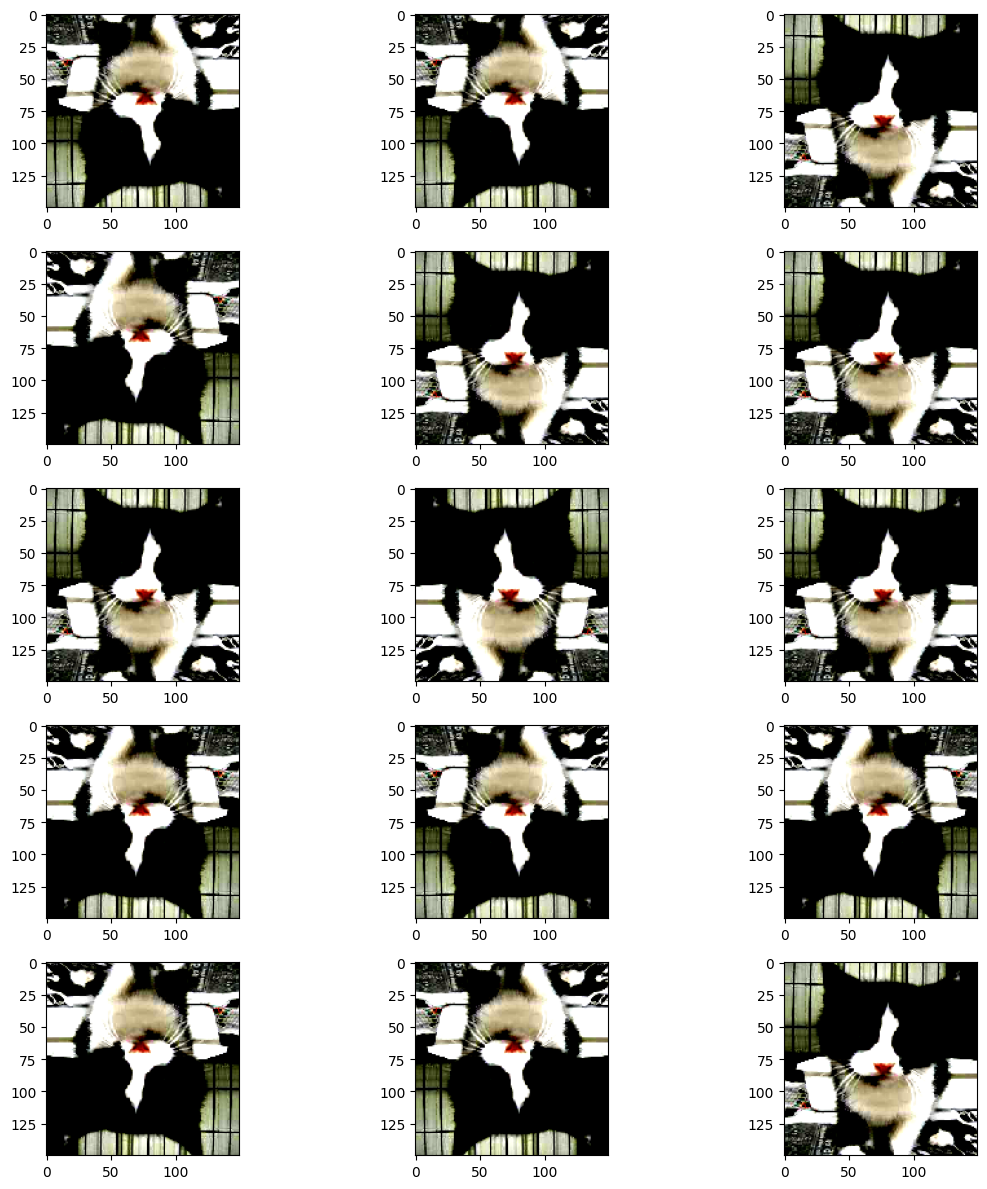

In [27]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X, Y in example_generator:
        image = X[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

## 13. Entrenemos el modelo!

In [28]:
epochs = 200

# Este FIT hay que cambiarlo!!

history = model.fit(train_generator, epochs=epochs,
                    validation_data=(x_val_scaled, y_val_encoded), batch_size=512,
                    callbacks=[callback_val_loss, callback_val_accuracy])

Epoch 1/200


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1862: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1885: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


167/167 [==============================] - 10s 49ms/step - loss: 1.0207 - accuracy: 0.5176 - val_loss: 0.7064 - val_accuracy: 0.4990
Epoch 2/200
167/167 [==============================] - 6s 36ms/step - loss: 0.6613 - accuracy: 0.5848 - val_loss: 0.6887 - val_accuracy: 0.5120
Epoch 3/200
167/167 [==============================] - 6s 34ms/step - loss: 0.6303 - accuracy: 0.6312 - val_loss: 0.7345 - val_accuracy: 0.5160
Epoch 4/200
167/167 [==============================] - 7s 44ms/step - loss: 0.5869 - accuracy: 0.6786 - val_loss: 0.8928 - val_accuracy: 0.5000
Epoch 5/200
167/167 [==============================] - 6s 34ms/step - loss: 0.5627 - accuracy: 0.7092 - val_loss: 1.0435 - val_accuracy: 0.5010
Epoch 6/200
167/167 [==============================] - 7s 39ms/step - loss: 0.5191 - accuracy: 0.7446 - val_loss: 1.0896 - val_accuracy: 0.5000
Epoch 7/200
167/167 [==============================] - 6s 38ms/step - loss: 0.5120 - accuracy: 0.7520 - val_loss: 1.0945 - val_accuracy: 0.5070


## 14. Guardemos el modelo

In [29]:
model.save(ruta+"model_con_data_augmentation.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 15. Veamos los resultados

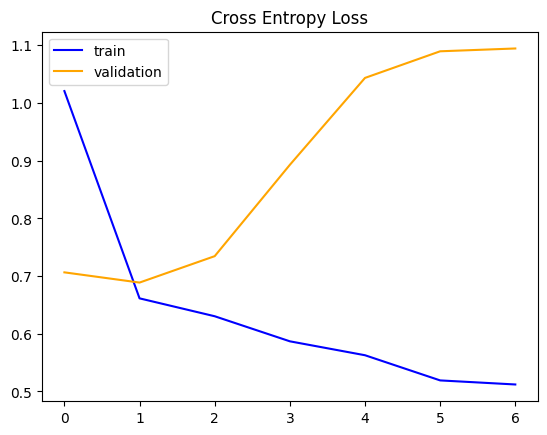

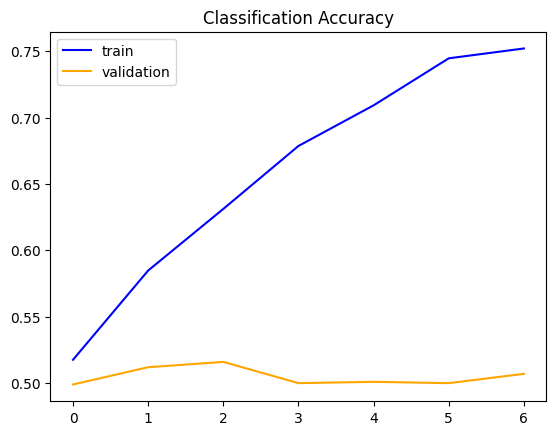

In [30]:
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='orange', label='validation')
plt.legend()
plt.show()

plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='blue', label='train')
plt.plot(history.history['val_accuracy'], color='orange', label='validation')
plt.legend()
plt.show()

In [31]:
_, acc = model.evaluate(x_test_scaled, y_test_encoded, verbose=0)
print('Test del Modelo con Data Augmentation > %.3f' % (acc * 100.0))

Test del Modelo con Data Augmentation > 51.600


## 16. Pintemos algunas predicciones

In [32]:
predictions = model.predict(x_test_scaled)


32/32 [==============================] - 0s 8ms/step


In [33]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  if true_label == 1:
    true_label = 'dog'
  else:
    true_label = 'cat'

  if np.max(predictions_array) > 0.50:
    predicted_label = 'dog'
  else:
    predicted_label = 'cat'

  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions_array),
                                true_label),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(1))
  plt.yticks([])

  if true_label == 1:
    true_label = 'dog'
  else:
    true_label = 'cat'

  if np.max(predictions_array) > 0.50:
    predicted_label = 'dog'
  else:
    predicted_label = 'cat'

  if predicted_label == true_label:
    color_plt = 'blue'
  else:
    color_plt = 'red'

  thisplot = plt.bar(range(1), np.max(predictions_array), color=color_plt)
  plt.ylim([0, 1])


Dibujamos los primeros digitos, con las predicciones y sus valores reales (un total de 20 imagenes, para no abusar de vuestros laptops)

Coloreamos las prediciones correctas en azul y los fallos en rojo

In [ ]:
num_rows = 5
num_cols = 4
start = 650
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i+start, predictions[i+start], y_test_encoded, x_test_scaled)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i+start, predictions[i+start], y_test_encoded)
plt.tight_layout()
plt.show()